In [14]:
import os
import torch
import torch.nn as nn
import numpy as np
from thingsvision import get_extractor
from thingsvision.utils.storing import save_features
from thingsvision.utils.data import ImageDataset, DataLoader
from thingsvision.core.extraction import center_features

# from google.colab import drive
from typing import Any, Dict, List

In [15]:
full_image_path = '/home/yifan/projects/deepdebugertool/thingsvision/imgs/'
full_output_path = '/home/yifan/projects/deepdebugertool/thingsvision/features'

In [16]:
def extract_features(
                    extractor: Any,
                    module_name: str,
                    image_path: str,
                    out_path: str,
                    batch_size: int,
                    flatten_activations: bool,
                    apply_center_crop: bool,
                    class_names: List[str]=None,
                    file_names: List[str]=None,
) -> np.ndarray:
    """Extract features for a single layer."""                                    
    dataset = ImageDataset(
        root=image_path,
        out_path=out_path,
        backend=extractor.get_backend(),
        transforms=extractor.get_transformations(apply_center_crop=apply_center_crop, resize_dim=256, crop_dim=224),
        class_names=class_names,
        file_names=file_names,
    )
    batches = DataLoader(
        dataset=dataset, 
        batch_size=batch_size, 
        backend=extractor.get_backend(),
        )
    features = extractor.extract_features(
                    batches=batches,
                    module_name=module_name,
                    flatten_acts=flatten_activations,
    )
    return features


def extract_all_layers(
                        model_name: str,
                        extractor: Any,
                        image_path: str,
                        out_path: str,
                        batch_size: int,
                        flatten_activations: bool,
                        apply_center_crop: bool,
                        layer: Any=nn.Linear,
                        class_names: List[str]=None,
                        file_names: List[str]=None,
) -> Dict[str, np.ndarray]:
    """Extract features for all selected layers and save them to disk."""
    features_per_layer = {}
    for l, (module_name, module) in enumerate(extractor.model.named_modules(), start=1):
        if isinstance(module, layer):
            # extract features for layer "module_name"
            features = extract_features(
                                        extractor=extractor,
                                        module_name=module_name,
                                        image_path=image_path,
                                        out_path=out_path,
                                        batch_size=batch_size,
                                        flatten_activations=flatten_activations,
                                        apply_center_crop=apply_center_crop,
                                        class_names=class_names,
                                        file_names=file_names,
            )
            # replace with e.g., [f'conv_{l:02d}'] or [f'fc_{l:02d}']
            features_per_layer[f'layer_{l:02d}'] = features
            # save features to disk
            save_features(features, out_path=f'{out_path}/features_{model_name}_{module_name}', file_format='npy')
    return features_per_layer

In [41]:
pretrained = True # use pretrained model weights
model_path = '/home/yifan/dataset/clean/pairflip/cifar10/0/Model/Epoch_200/subject_model.pth' # if pretrained = False (i.e., randomly initialized weights) set path to model weights
batch_size = 32 # use a power of two (this can be any size, depending on the number of images for which you aim to extract features)
apply_center_crop = True # center crop images (set to False, if you don't want to center-crop images)
flatten_activations = True # whether or not features (e.g., of Conv layers) should be flattened
class_names = ['horse','truck','car','frog','cat','dog','plane']  # optional list of class names for class dataset
file_names = None # optional list of file names according to which features should be sorted
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
GPU_ID = 0
# device = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [42]:
# load model
model_name = 'resnet18' 
# specify model source 
# we use torchvision here (https://pytorch.org/vision/stable/models.html)
source = 'torchvision'
# initialize the extractor
extractor = get_extractor( 
            model_name=model_name,
            pretrained=pretrained,
            model_path=None,
            device=device,
            source=source
)

In [34]:
module_name = 'layer4.1.bn2' 

In [43]:
# extract features for a single layer (e.g., penultimate)
features = extract_features(
                            extractor=extractor,
                            module_name=module_name,
                            image_path=full_image_path,
                            out_path=full_output_path,
                            batch_size=batch_size,
                            flatten_activations=flatten_activations,
                            apply_center_crop=apply_center_crop,
                            class_names=class_names,
                            file_names=file_names,
)

# apply centering (not necessary, but may be desirable, depending on the analysis)
features = center_features(features)

# save features to disk
save_features(features, out_path=f'{full_output_path}/features_{model_name}_{module_name}', file_format='npy')


...Creating dataset.


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

...Features successfully extracted for all 13 images in the database.
...Features shape: (13, 25088)
...Features successfully saved to disk.



In [36]:
from thingsvision.core.rsa import compute_rdm, plot_rdm

In [44]:
# extract features
clip_features = extract_features(
                            extractor=extractor,
                            module_name=module_name,
                            image_path=full_image_path,
                            out_path=full_output_path,
                            batch_size=batch_size,
                            flatten_activations=flatten_activations,
                            apply_center_crop=apply_center_crop,
                            class_names=class_names,
                            file_names=file_names,
)

# apply centering (not necessary, but may be desirable, depending on the analysis)
clip_features = center_features(clip_features)

# save features to disk
save_features(clip_features, out_path=f'{full_output_path}/features_{model_name}_{module_name}', file_format='npy')


...Creating dataset.


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

...Features successfully extracted for all 13 images in the database.
...Features shape: (13, 25088)
...Features successfully saved to disk.



In [45]:
rdm = compute_rdm(clip_features, method='correlation')

In [46]:
rdm

array([[0.0000000e+00, 9.2542642e-01, 9.2135382e-01, 1.0031199e+00,
        1.2158731e+00, 1.0009238e+00, 1.2223837e+00, 1.0815884e+00,
        1.0780226e+00, 1.1088941e+00, 1.0143086e+00, 1.1849864e+00,
        1.1794584e+00],
       [9.2542642e-01, 5.9604645e-08, 9.6646756e-01, 7.8729630e-01,
        1.1799173e+00, 1.1857766e+00, 1.1989305e+00, 1.0773959e+00,
        1.1202741e+00, 1.1615032e+00, 9.5259577e-01, 1.2283158e+00,
        1.1171916e+00],
       [9.2135382e-01, 9.6646756e-01, 0.0000000e+00, 9.3620831e-01,
        1.1298075e+00, 1.1575840e+00, 1.0615116e+00, 1.1289190e+00,
        1.1944146e+00, 1.1320622e+00, 1.0984472e+00, 1.0863258e+00,
        1.1327848e+00],
       [1.0031199e+00, 7.8729630e-01, 9.3620831e-01, 0.0000000e+00,
        1.2293463e+00, 1.1692133e+00, 1.1887636e+00, 1.0799038e+00,
        1.0175102e+00, 1.1596608e+00, 1.1019015e+00, 1.1819472e+00,
        1.1328762e+00],
       [1.2158731e+00, 1.1799173e+00, 1.1298075e+00, 1.2293463e+00,
        0.0000000e+0

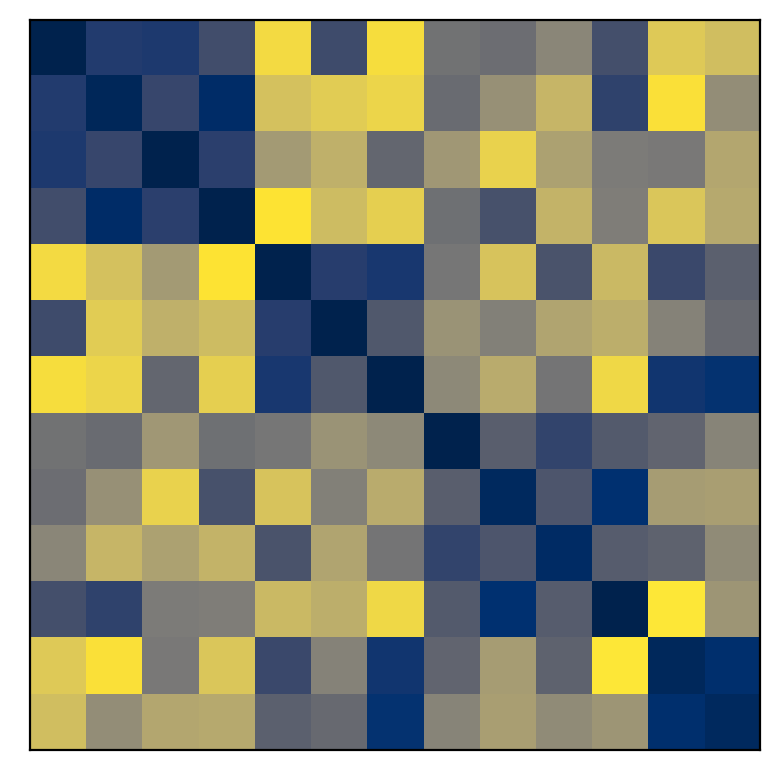

In [47]:
# plot rdm
plot_rdm(
        full_output_path,
        clip_features,
        method='correlation',
        format='.png', # '.jpg'
        colormap='cividis',
        show_plot=True,
)